# Assignment 2 - Association Rule Mining

## 1 Preprocessing

### 1.1 Import the Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import csv
import time
import itertools
from itertools import combinations
import mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## 1.2 Read each row of data

In [2]:
import os
os.chdir("/Users/bytedance/Desktop/datasets/")

In [3]:
def preprocessing_open_csv(csvfile):
    with open(csvfile) as csvfile:
        reader = csv.reader(csvfile)
        data = []
        for row in reader:
            data.append(row)
        data = [[elem for elem in inner_list if elem != ''] for inner_list in data]
        df = pd.DataFrame(data)
    return df

In [4]:
datasets = ['dataset1.csv', 'dataset2.csv', 'dataset3.csv', 'dataset4.csv', 'dataset5.csv', 'dataset6.csv', 'dataset7.csv', 'dataset8.csv']

In [5]:
dfs = {}
for dataset in datasets:
    df = preprocessing_open_csv(dataset)
    dfs[dataset] = df

In [6]:
df1, df2, df3, df4, df5, df6, df7, df8 = dfs['dataset1.csv'], dfs['dataset2.csv'], dfs['dataset3.csv'], dfs['dataset4.csv'], dfs['dataset5.csv'], dfs['dataset6.csv'], dfs['dataset7.csv'], dfs['dataset8.csv']

In [7]:
print(df1)

                0              1              2              3           4   \
0           ﻿Lassi  Coffee Powder         Butter        Yougurt        Ghee   
1             Ghee  Coffee Powder           None           None        None   
2            Lassi     Tea Powder         Butter         Cheese        None   
3           Cheese     Tea Powder         Panner  Coffee Powder      Butter   
4           Cheese        Yougurt  Coffee Powder          Sugar      Butter   
..             ...            ...            ...            ...         ...   
795         Cheese          Lassi           Ghee         Butter  Tea Powder   
796  Coffee Powder          Sugar        Yougurt          Bread        None   
797           Milk          Lassi         Cheese           Ghee  Tea Powder   
798           Ghee          Sweet  Coffee Powder         Butter        Milk   
799     Tea Powder           Milk        Yougurt          Sugar       Sweet   

         5      6     7     8     9     10  
0    C

In [8]:
def get_row_length(df):
    row_lengths = []
    for i in range(len(df)):
        row_list = [x for x in df.iloc[i].values.tolist() if x is not None]
        row_lengths.append(len(row_list))
    avg_row_length = sum(row_lengths) / len(df)
    return avg_row_length

In [9]:
avg_row_length1, avg_row_length2, avg_row_length3, avg_row_length4, avg_row_length5, avg_row_length6, avg_row_length7, avg_row_length8 = get_row_length(df1), get_row_length(df2), get_row_length(df3), get_row_length(df4), get_row_length(df5), get_row_length(df6), get_row_length(df7), get_row_length(df8)

In [34]:
avg_row_length1

5.13875

In [11]:
# Get the unique values in each column
distinct_values = {}
for col in df2.columns:
    distinct_values[col] = df2[col].unique()

# Count the number of distinct values in each column
num_distinct_values = {}
for col, values in distinct_values.items():
    num_distinct_values[col] = len(values)

# Print the number of distinct values in each column
for col, num in num_distinct_values.items():
    print(f'The column {col} has {num} distinct values.')

The column 0 has 12 distinct values.
The column 1 has 12 distinct values.
The column 2 has 13 distinct values.
The column 3 has 13 distinct values.
The column 4 has 13 distinct values.
The column 5 has 13 distinct values.
The column 6 has 13 distinct values.
The column 7 has 13 distinct values.
The column 8 has 11 distinct values.
The column 9 has 3 distinct values.


# 2 Association Rule Mining

## 2.1 Brute Force

In [12]:
def brute_force(df, min_support):
    transactions = []
    for index, row in df.iterrows():
        transaction = []
        for item in row:
            transaction.append(str(item))
        transactions.append(transaction)
    transactions = [[elem for elem in inner_list if elem != 'None'] for inner_list in transactions]

    items = set()
    for transaction in transactions:
        for item in transaction:
            items.add(item)


    candidate_itemsets = []
    for i in range(2, len(items)+1):
        for itemset in itertools.combinations(items, i):
            candidate_itemsets.append(itemset)


    frequent_itemsets = []
    for itemset in candidate_itemsets:
        support = 0
        for transaction in transactions:
            if set(itemset).issubset(transaction):
                support += 1
        if support/len(transactions) >= min_support:
            frequent_itemsets.append((support/len(transactions), itemset))

    association_rules_bf = []
    for itemset in frequent_itemsets:
        for i in range(1, len(itemset[1])):
            for antecedent in itertools.combinations(itemset[1], i):
                antecedent = frozenset(antecedent)
                consequent = set(itemset[1]).difference(antecedent)
                support_antecedent = 0
                support_itemset = itemset[0]*len(transactions)
                for transaction in transactions:
                    if antecedent.issubset(transaction):
                        support_antecedent += 1
                confidence = support_itemset/support_antecedent
                lift = confidence/(len(transactions)*support_antecedent/len(transactions)*support_itemset/len(transactions))
                if confidence >= 0.5:
                    association_rules_bf.append((antecedent, consequent, confidence))


    df_frequent_itemsets = pd.DataFrame(frequent_itemsets, columns=['support', 'itemsets'])
    df_frequent_itemsets['itemsets'] = df_frequent_itemsets['itemsets'].apply(lambda x: '(' + ', '.join(list(x)) + ')' if len(x) > 1 else '(' + list(x)[0] + ')')
    df_association_rules_bf = pd.DataFrame(association_rules_bf, columns=['antecedents', 'consequents', 'confidence'])
    df_association_rules_bf['antecedents'] = df_association_rules_bf['antecedents'].apply(lambda x: '(' + ', '.join(list(x)) + ')' if len(x) > 1 else '(' + list(x)[0] + ')')
    df_association_rules_bf['consequents'] = df_association_rules_bf['consequents'].apply(lambda x: '(' + ', '.join(list(x)) + ')' if len(x) > 1 else '(' + list(x)[0] + ')')


    return df_frequent_itemsets, df_association_rules_bf

In [13]:
bf_times = []
for data in [df1]:
    # Measure execution time for brute force
    start_time = time.time()
    df_frequent_itemsets, df_association_rules_bf = brute_force(data, min_support = 0.1)
    bf_times1 = time.time() - start_time

In [14]:
bf_times1

2.0476553440093994

In [15]:
c = bf_times1/ avg_row_length1 / pow(2, 13)/ len(df1)

In [16]:
c

6.080222032000059e-08

In [17]:
bf_times2 = c * avg_row_length2 * pow(2, 13) * len(df2)
bf_times3 = c * avg_row_length3 * pow(2, 13) * len(df3)
bf_times4 = c * avg_row_length4 * pow(2, 13) * len(df4)
bf_times5 = c * avg_row_length5 * pow(2, 13) * len(df5)
bf_times6 = c * avg_row_length6 * pow(2, 13) * len(df6)
bf_times7 = c * avg_row_length7 * pow(2, 13) * len(df7)
bf_times8 = c * avg_row_length8 * pow(2, 13) * len(df8)

In [18]:
bf_times8

3.915001460450956

In [19]:
bf_times = [bf_times1, bf_times2, bf_times3, bf_times4, bf_times5, bf_times6, bf_times7, bf_times8]

In [20]:
print(df_frequent_itemsets)

     support                             itemsets
0    0.19750                        (Sweet, Milk)
1    0.16625                      (Sweet, Panner)
2    0.18750                        (Sweet, Ghee)
3    0.19625                      (Sweet, Butter)
4    0.18625                     (Sweet, Yougurt)
..       ...                                  ...
106  0.10250   (Bread, Coffee Powder, Tea Powder)
107  0.10625       (Lassi, Cheese, Coffee Powder)
108  0.10625        (Lassi, Coffee Powder, Sugar)
109  0.10750   (Lassi, Coffee Powder, Tea Powder)
110  0.10375  (Cheese, Coffee Powder, Tea Powder)

[111 rows x 2 columns]


In [21]:
print(df_association_rules_bf)

                    antecedents      consequents  confidence
0                       (Sugar)         (Butter)    0.526316
1                       (Lassi)  (Coffee Powder)    0.534535
2                 (Sweet, Milk)  (Coffee Powder)    0.525316
3         (Milk, Coffee Powder)          (Sweet)    0.518750
4               (Sweet, Butter)  (Coffee Powder)    0.528662
..                          ...              ...         ...
90       (Coffee Powder, Sugar)          (Lassi)    0.559211
91          (Lassi, Tea Powder)  (Coffee Powder)    0.565789
92  (Coffee Powder, Tea Powder)          (Lassi)    0.505882
93      (Coffee Powder, Cheese)     (Tea Powder)    0.512346
94         (Tea Powder, Cheese)  (Coffee Powder)    0.549669

[95 rows x 3 columns]


## 2.2 Apriori Rule Mining

In [26]:
def transactions_to_dataframe(csvfile):
    with open(csvfile) as csvfile:
        reader = csv.reader(csvfile)
        data = []
        for row in reader:
            data.append(row)
        data = [[elem for elem in inner_list if elem != ''] for inner_list in data]
        te = TransactionEncoder()
        te_data = te.fit_transform(data)
        df = pd.DataFrame(te_data, columns=te.columns_)
    return df

In [27]:
dfs = {}
for dataset in datasets:
    df = transactions_to_dataframe(dataset)
    dfs[dataset] = df

In [28]:
df1, df2, df3, df4, df5, df6, df7, df8 = dfs['dataset1.csv'], dfs['dataset2.csv'], dfs['dataset3.csv'], dfs['dataset4.csv'], dfs['dataset5.csv'], dfs['dataset6.csv'], dfs['dataset7.csv'], dfs['dataset8.csv']

In [29]:
print(df1)

     Bread  Butter  Cheese  Coffee Powder   Ghee  Lassi   Milk  Panner  Sugar  \
0    False    True    True           True   True  False  False   False  False   
1    False   False   False           True   True  False  False   False  False   
2    False    True    True          False  False   True  False   False  False   
3     True    True    True           True  False  False  False    True  False   
4    False    True    True           True  False  False  False   False   True   
..     ...     ...     ...            ...    ...    ...    ...     ...    ...   
795  False    True    True          False   True   True  False   False  False   
796   True   False   False           True  False  False  False   False   True   
797   True   False    True          False   True   True   True   False  False   
798   True    True   False           True   True  False   True   False  False   
799  False   False   False          False  False  False   True   False   True   

     Sweet  Tea Powder  You

In [30]:
# Measure the execution time for Apriori algorithm and brute force approach for each dataset
apriori_times = []

min_support = 0.1

for data in [df1, df2, df3, df4, df5, df6, df7, df8]:
    # Measure execution time for Apriori
    start_time = time.time()
    frequent_itemsets_ap = apriori(data, min_support = min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets_ap, metric="confidence", min_threshold=0.5)
    apriori_times.append(time.time() - start_time)

In [31]:
print(rules)

              antecedents      consequents  antecedent support  \
0                  (Ghee)  (Coffee Powder)            0.427333   
1                (Panner)  (Coffee Powder)            0.431333   
2                 (Sugar)  (Coffee Powder)            0.442000   
3                 (Lassi)           (Milk)            0.436667   
4                  (Milk)          (Sugar)            0.446667   
..                    ...              ...                 ...   
81       (Yougurt, Sugar)           (Milk)            0.208000   
82       (Sweet, Yougurt)           (Milk)            0.194000   
83          (Sweet, Milk)        (Yougurt)            0.190000   
84     (Milk, Tea Powder)        (Yougurt)            0.208667   
85  (Yougurt, Tea Powder)           (Milk)            0.208667   

    consequent support   support  confidence      lift  leverage  conviction  
0             0.461333  0.214000    0.500780  1.085506  0.016857    1.079017  
1             0.461333  0.217333    0.503864  1.0

In [32]:
apriori_times

[0.006740093231201172,
 0.0062940120697021484,
 0.004728794097900391,
 0.004924297332763672,
 0.005218029022216797,
 0.005267143249511719,
 0.005986928939819336,
 0.006747722625732422]

## 2.3 Comparison

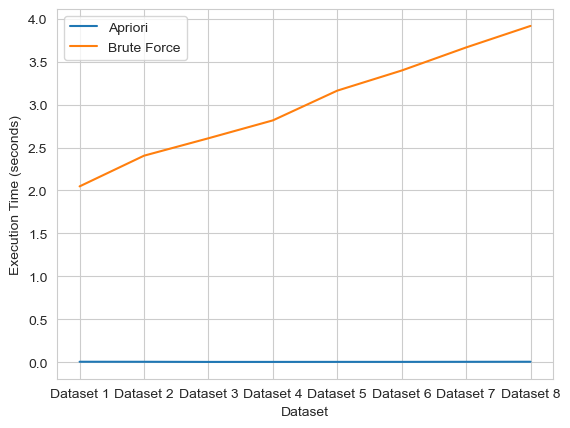

In [33]:
# Plot the execution times for both the approaches on the same graph
datasets = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4', 'Dataset 5', 'Dataset 6', 'Dataset 7', 'Dataset 8']
plt.plot(datasets, apriori_times, label='Apriori')
plt.plot(datasets, bf_times, label='Brute Force')
plt.xlabel('Dataset')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.show()